# Overview

The aim of this task is to create a convolutional neural net (CNN) which will classify pictures of LEGO bricks based on their shape.  

# Import of libraries

In [2]:
import numpy as np
import pandas as pd
from keras.utils import np_utils
from keras import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import joblib
import random
import warnings
warnings.filterwarnings("always")
from keras.applications import Xception
from keras import backend as K
from scipy.misc import imsave

Using TensorFlow backend.


# Data preprocessing

In [0]:
# setting paths to train, validation and test directories 
train_data_dir = "data/LEGO brick images/train/"
validation_data_dir = "data/LEGO brick images/valid/"
test_data_dir = "data/LEGO brick images/pred/"

#### Renaming subdirectories

I need to clean names of subdirectories in train directory as they will be treated as names of classes and they contain reduntant numbers in the beginning.

In [0]:
def rename_subdirs(root_dir_path):
    '''Function cleaning names of subdirectories.'''
    for dir_path, dir_names, file_names in os.walk(root_dir_path):
        for dir_name in dir_names:
            os.rename(os.path.join(root_dir_path, dir_name), os.path.join(root_dir_path, dir_name[5:]))

In [0]:
#rename_subdirs(train_data_dir)

In [0]:
classes = os.listdir(train_data_dir)
print(f"There are {len(classes)} classes.\n {classes}")

There are 16 classes.
 ['Plate 2x2', 'Brick 2x2', ' Cross Axle 2M with Snap friction', 'Plate 1X2 with 1 Knob', 'Plate 1x1', ' Bush 3M friction with Cross axle', 'Peg 2M', 'Technic Lever 3M', 'Plate 1x2', 'Bush for Cross Axle', 'Brick 1x1', 'Flat Tile 1x2', 'Brick corner 1x2x2', 'Brick 1x2', ' half Bush', 'Roof Tile 1x2x45deg']


#### Moving files to validation set

I need to create validation set and arrange it in the same directory and subdirectories structure as train set. This structure will be necessary later when using ImageDataGenerator and its method "flow_from_directory". I will allocate 30% of images from train set to validation set. I will sample random 120 files from every class subdirectory and move them to validation subdirectory.

In [0]:
def create_dir_same_structure(inputpath, outputpath):
    '''Function creating directory with the same structure as another directory.'''
    for dir_path, dir_names, file_names in os.walk(inputpath):
        structure = os.path.join(outputpath, dir_path[len(inputpath):])
        os.mkdir(structure)

In [0]:
# creating validation directory with the same structure as in train dir
create_dir_same_structure(train_data_dir, validation_data_dir)

In [0]:
# creating test directory with the same structure as in train dir
create_dir_same_structure(train_data_dir, test_data_dir)

In [0]:
def move_random_files(source_path, destination_path):
    '''Function moving randomly sampled files to another directory.'''
    subdirs = os.listdir(source_path)
    for subdir in subdirs:
        files = os.listdir(os.path.join(source_path, subdir))
        random_files = random.sample(files, 120)
        for random_file in random_files:
            os.rename(os.path.join(source_path, subdir, random_file), os.path.join(destination_path, subdir, random_file))

In [0]:
# moving 120 random files from subdirs in train directory to subdirs in validation directory
move_random_files(train_data_dir, validation_data_dir)

#### Images preprocessing

Pictures preprocessing for this task will consist of the following steps:

1. Ensuring uniform aspect ratio (pictures has to be squares).

2. Image Scaling: using predefined width and height.

3. Normalizing image inputs.

4. Data augmentation to prevent overfitting and ensure the model generalizes well.


In [9]:
# checking size of a picture
img = Image.open("data/train/Brick corner 1x2x2/201706171206-0001.png")
img_array = np.array(img)
print(f"Size of the picture: {img_array.shape}")

Size of the picture: (200, 200, 4)


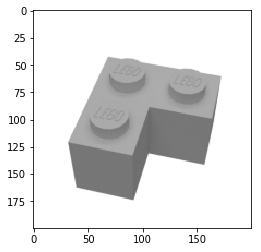

In [0]:
# printing image
plt.imshow(img)
plt.show()

Our pictures have 4 channels, which means that they are actually RGBa (alpha channel for opaqueness).

### Data augmentation and normalization

For data loading and augmentation I will use ImageDataGenerator, which generates batches of augmented images on the fly. Transformations are chosen randomly from the listed parameters and applied to images. It helps prevent overfitting as the model will learn on different images and so will generalize better.  ImageDataGenerator class' method "flow_from_directory" is very useful when the images are saved in directories named after classes.

I will use the following transformations:

* zoom: it will be very useful to make the model robust to seeing bricks of different sizes in the test set
* rescale: pixels differ in intensity of gray on the scale 0-255, we normalize it into 0-1
* brigthness: darkening (when <1) or lightening (when >1) the image


In this case, I won't need such popular augmentations as rotation and horizontal/vertical flip as there are plenty of pictures of rotated bricks. 

In [10]:
# Constructing and configuring 3 instances of the ImageDataGenerator class for train, validation and test sets

# data augmentation configuration for train images
train_generator = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.2,
                                     brightness_range=[0.5,1.5])

# validation and test data will be only rescaled
validation_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:440: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  image.ImageDataGenerator.__init__).args:
/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:440: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  image.ImageDataGenerator.__init__).args:
/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:440: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  image.ImageDataGenerator.__init__).args:


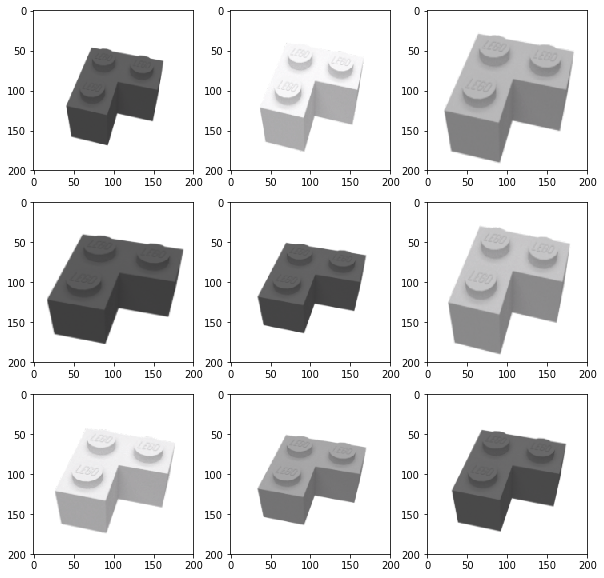

In [0]:
# visualising augementations on the previously loaded image

i=0
plt.figure(figsize=(10,10))
# I have to expand dimension of the image as it has to be rank 4
# my data format is (samples, height, width, channels) so the new axis has to be placed first
img = np.expand_dims(img, 0)
for img_batch in train_generator.flow(img, batch_size=9, shuffle=False):
    for img in img_batch:
        plt.subplot(330 + 1 + i)
        plt.imshow(img)
        i=i+1    
    if i >= 9:
        break
plt.show()

In [13]:
# invoking flow_from_directory method to generate batches of augmented images 

batch_size=16
h, w = 200, 200

train_flow = train_generator.flow_from_directory(
    directory=train_data_dir, 
    target_size=(h,w), color_mode="rgba", class_mode="categorical", shuffle=True, batch_size=batch_size)

# I need two instances of validation flow: for fit_generator yielding images in batches 
# and for evaluation yielding images one by one (treated as test set)

validation_flow_fit = validation_generator.flow_from_directory(
    directory=validation_data_dir, 
    target_size=(h,w), color_mode="rgba", class_mode="categorical", shuffle=True, batch_size=batch_size)

validation_flow_eval = validation_generator.flow_from_directory(
    directory=validation_data_dir, 
    target_size=(h,w), color_mode="rgba", class_mode="categorical", batch_size=1)

test_flow = test_generator.flow_from_directory(
    directory=test_data_dir, 
    target_size=(h,w), color_mode="rgba", class_mode="categorical", batch_size=1)

Found 4459 images belonging to 16 classes.
Found 1920 images belonging to 16 classes.
Found 1920 images belonging to 16 classes.
Found 16 images belonging to 16 classes.


# Building CNNs

In [0]:
# setting variables with number of files in train and validation directories 
nb_train_samples = sum([len(files) for r, d, files in os.walk(train_data_dir)])
nb_validation_samples = sum([len(files) for r, d, files in os.walk(validation_data_dir)])
nb_test_samples = sum([len(files) for r, d, files in os.walk(test_data_dir)])

In [0]:
def build_model(list_of_layers):
  
    model = Sequential() 
  
    for layer in list_of_layers:
        model.add(layer)
    
    model.summary() 
  
    model.compile(loss="categorical_crossentropy",
               optimizer="adam", 
               metrics=["categorical_accuracy"])
    return model

In [0]:
def evaluate_model(model, filename):
    
    early_stopping = EarlyStopping(patience=5, monitor="val_loss")
    take_best_model = ModelCheckpoint(str(filename)+".h5py", save_best_only=True)
    
    batch_size=16
    history = model.fit_generator(generator=train_flow, 
                       steps_per_epoch=nb_train_samples//batch_size, 
                       validation_data=validation_flow_fit,
                       validation_steps=nb_validation_samples//batch_size,
                       epochs=50,
                       callbacks=[take_best_model, early_stopping])
    
    joblib.dump(history, filename)
    
    model.load_weights(str(filename)+".h5py")
    
    return model.evaluate_generator(generator=validation_flow_eval,
                                   steps=nb_validation_samples)[1]

I will try several architectures of convolutional neural networks. They will differ in the number of convolutional and dense layers, number of filters and their size and number of neurons in Dense layers. Architectures will be inspired by some famous nets like LeNet, AlexNet, VGG. Some characteristics:

* ** regularization**: In some architectures I will use batch normalization in convolutional part of the network and Dropout before in the fully connected part. Apart from regularization, batch normalization should also make models resistant to vanishing gradient problem. 
* **padding**: I will use padding as zoomed images (during augmentation) may be close to the border.
* **filters' size**: as shape recognition in this case doesn't rely on the details I won't use 3x3 filters (mostly 5x5) 

In [0]:
models = {        
            "lenet_like":          [Conv2D(6,(5,5),activation="relu",padding="same", input_shape=img_array.shape),
                                   MaxPooling2D((2,2)),
                                   Conv2D(16,(5,5),activation="relu",padding="same"),
                                   MaxPooling2D((2,2)),
                                   Conv2D(32,(5,5),activation="relu",padding="same"),
                                   MaxPooling2D((2,2)),
                                   Flatten(),
                                   Dense(84,activation="relu"),
                                   Dense(16,activation="softmax")],
    
            "alexnet_like":        [Conv2D(16,(11,11),activation="relu",padding="same", input_shape=img_array.shape),
                                   MaxPooling2D((3,3)),
                                   BatchNormalization(),
                                   Conv2D(32,(5,5),activation="relu",padding="same"),
                                   MaxPooling2D((3,3)),
                                   BatchNormalization(),
                                   Conv2D(64,(5,5),activation="relu",padding="same"),
                                   MaxPooling2D((2,2)),
                                   Flatten(),
                                   Dropout(0.5),
                                   Dense(84,activation="relu"),
                                   Dense(16,activation="softmax")],
    
            "vgg_like":            [Conv2D(16,(5,5),activation="relu",padding="same",input_shape=img_array.shape),
                                   Conv2D(16,(5,5),activation="relu",padding="same"),
                                   MaxPooling2D((2,2)),
                                   Conv2D(32,(5,5),activation="relu",padding="same"),
                                   Conv2D(32,(5,5),activation="relu",padding="same"),
                                   MaxPooling2D((2,2)),
                                   Flatten(),
                                   Dense(64,activation="relu"),
                                   Dense(64, activation="relu"),
                                   Dense(16,activation="softmax")]   
}

In [0]:
lst_acc = []
for model, params in models.items():
    acc = (evaluate_model(build_model(params), model))
    lst_acc.append(acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 200, 200, 6)       606       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 100, 100, 6)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 100, 100, 16)      2416      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 50, 50, 32)        12832     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 20000)             0         
__________

In [0]:
# printing accuracy of models
model_results = pd.DataFrame(list(zip(models.keys(), lst_acc)), columns=["model", "accuracy"]).sort_values(by="accuracy", ascending=False).reset_index(drop=True)

In [0]:
model_results

,model,accuracy
0,lenet_like,0.916146
1,vgg_like,0.888021
2,alexnet_like,0.878125


In [0]:
def plot_accuracy(path, models):
    '''Function to plot accuracy on train and validation sets.'''
    for model in models:
        history = joblib.load(os.path.join(path_to_results, model))
        plt.plot(history.history['categorical_accuracy'])
        plt.plot(history.history['val_categorical_accuracy'])
        plt.title(f"model {model} accuracy")
        plt.ylabel('accuracy')
        plt.ylim(0.6, 1)
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.show()

In [0]:
def plot_loss(path, models):
    '''Function to plot loss on train and validation sets.'''
    for model in models:
        history = joblib.load(os.path.join(path_to_results, model))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f"model {model} loss")
        plt.ylabel('loss')
        plt.ylim(0.6, 1)
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.show()

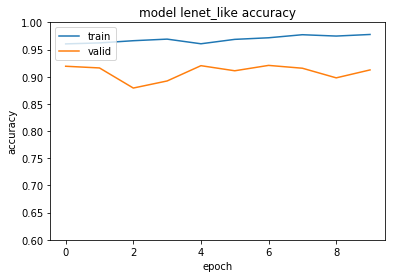

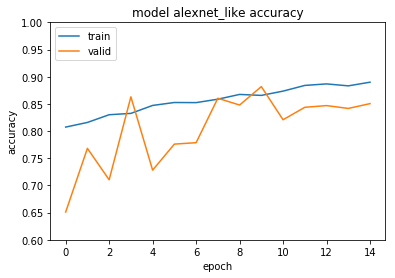

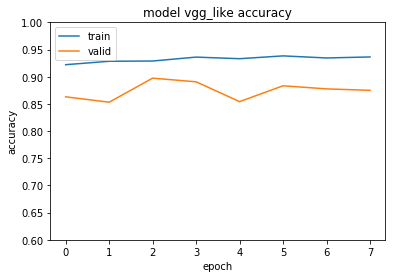

In [0]:
# plotting accuracy of models for train and validation sets
path_to_results = "data/results"
plot_accuracy(path_to_results, models)

Accuracies of the models are similiar with LeNet style model performing best (0,916 on the validation set). The models don't seem to be overfitting a lot as the discrepancy between accuracy on the train and validation set reaches ca. 6 percentage points at its highest (usually ca. 4 percentage points). The models were fitted using EarlyStopping callback with patience=5 and as a result were trained only for 8-15 epochs. On the plots above there is no clear point of divergence between train and validation accuracies and the falls in validation loss (monitor for EarlyStopping) could be temporal. So now I will train the models for 50 epochs to check if they perform better or if there's a clear point where they begin to overfit.



In [0]:
#training CNNs for 50 epochs
lst_acc = []
for model, params in models.items():
    acc = (evaluate_model(build_model(params), model))
    lst_acc.append(acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 6)       606       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 6)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        12832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
__________

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Epoch 1/50
278/278 [==============================] - 86s 309ms/step - loss: 1.3060 - categorical_accuracy: 0.5251 - val_loss: 0.9225 - val_categorical_accuracy: 0.6729
Epoch 2/50
278/278 [==============================] - 81s 292ms/step - loss: 0.8892 - categorical_accuracy: 0.6683 - val_loss: 0.6307 - val_categorical_accuracy: 0.7854
Epoch 3/50
278/278 [==============================] - 83s 300ms/step - loss: 0.7706 - categorical_accuracy: 0.7187 - val_loss: 0.5948 - val_categorical_accuracy: 0.7807
Epoch 4/50
278/278 [==============================] - 84s 302ms/step - loss: 0.6282 - categorical_accuracy: 0.7727 - val_loss: 0.4887 - val_categorical_accuracy: 0.8151
Epoch 5/50
278/278 [==============================] - 84s 303ms/step - loss: 0.5372 - categorical_accuracy: 0.7996 - val_loss: 0.4801 - val_categorical_accuracy: 0.8203
Epoch 6/50
278/278 [==============================] - 82s 293ms/step - loss: 0.4771 - categorical_accuracy: 0.8261 - val_loss: 0.4050 - val_categorical_acc

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 200, 200, 16)      7760      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 66, 66, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 16)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 66, 66, 32)        12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 22, 32)        128       
___________________________

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Epoch 1/50
278/278 [==============================] - 85s 305ms/step - loss: 2.0275 - categorical_accuracy: 0.3100 - val_loss: 1.5878 - val_categorical_accuracy: 0.4719
Epoch 2/50
278/278 [==============================] - 80s 289ms/step - loss: 1.5011 - categorical_accuracy: 0.4392 - val_loss: 1.0453 - val_categorical_accuracy: 0.5729
Epoch 3/50
278/278 [==============================] - 80s 289ms/step - loss: 1.2611 - categorical_accuracy: 0.5120 - val_loss: 1.0004 - val_categorical_accuracy: 0.6135
Epoch 4/50
278/278 [==============================] - 80s 290ms/step - loss: 1.0992 - categorical_accuracy: 0.5760 - val_loss: 0.8825 - val_categorical_accuracy: 0.6536
Epoch 5/50
278/278 [==============================] - 81s 291ms/step - loss: 1.0205 - categorical_accuracy: 0.6067 - val_loss: 0.8519 - val_categorical_accuracy: 0.6516
Epoch 6/50
278/278 [==============================] - 81s 291ms/step - loss: 0.8789 - categorical_accuracy: 0.6500 - val_loss: 0.7353 - val_categorical_acc

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 200, 200, 16)      1616      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 200, 200, 16)      6416      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 32)      12832     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 32)      25632     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 80000)             0         
__________

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Epoch 1/50
278/278 [==============================] - 90s 325ms/step - loss: 1.5511 - categorical_accuracy: 0.4549 - val_loss: 0.8883 - val_categorical_accuracy: 0.6609
Epoch 2/50
278/278 [==============================] - 86s 309ms/step - loss: 0.9799 - categorical_accuracy: 0.6382 - val_loss: 0.7640 - val_categorical_accuracy: 0.7094
Epoch 3/50
278/278 [==============================] - 86s 311ms/step - loss: 0.8557 - categorical_accuracy: 0.6909 - val_loss: 0.6586 - val_categorical_accuracy: 0.7568
Epoch 4/50
278/278 [==============================] - 87s 312ms/step - loss: 0.7251 - categorical_accuracy: 0.7274 - val_loss: 0.6249 - val_categorical_accuracy: 0.7766
Epoch 5/50
278/278 [==============================] - 88s 316ms/step - loss: 0.6222 - categorical_accuracy: 0.7770 - val_loss: 0.5350 - val_categorical_accuracy: 0.7927
Epoch 6/50
278/278 [==============================] - 86s 310ms/step - loss: 0.5449 - categorical_accuracy: 0.7957 - val_loss: 0.5537 - val_categorical_acc

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


In [0]:
# printing accuracy of models
model_results = pd.DataFrame(list(zip(models.keys(), lst_acc)), columns=["model", "accuracy"]).sort_values(by="accuracy", ascending=False).reset_index(drop=True)

In [0]:
model_results

,model,accuracy
0,lenet_like,0.948958
1,alexnet_like,0.934375
2,vgg_like,0.926042


Still LeNet style model performed best with slightly higher accuracy. Longer training also improved performance of the remaining models. Let's check on the plots if they are not overfitted.

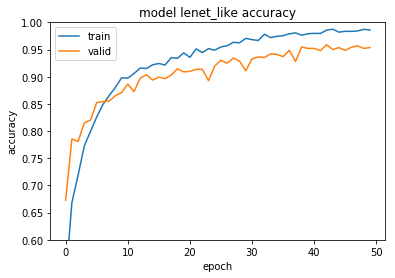

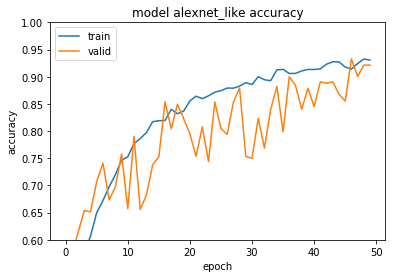

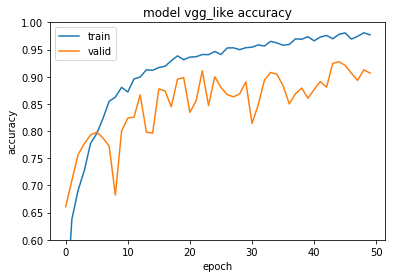

In [0]:
# plotting accuracy of models for train and validation sets
path_to_results = "data/results"
plot_accuracy(path_to_results, models)

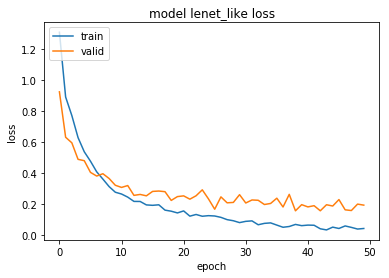

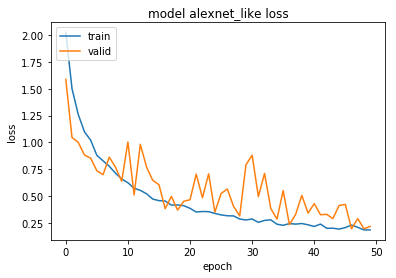

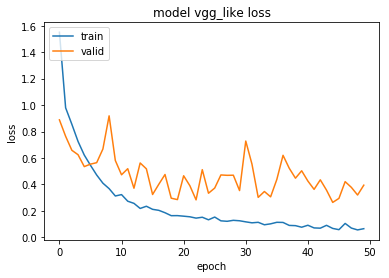

In [0]:
# plotting loss of models for train and validation sets
path_to_results = "data/results"
plot_loss(path_to_results, models)

VGG style model seems to be most overfitted. LeNet style model's discrepancy between train and validation accuracy seems to be reasonable and least volatile of all the models. Now I will check how best model scores on the unseen test set.

# Results on test set

I will load LeNet style model trained for 10 epochs (from the first round of models training), load its weights from the file and evaluate its performance on the test set.

In [19]:
# loading best model's weights from a file

best_model = build_model(models["lenet_like"])
best_model.load_weights("data/results/lenet_like.h5py")
best_model.compile(loss="categorical_crossentropy",
               optimizer="adam", 
               metrics=["categorical_accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 6)       606       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 6)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        12832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
flat

In [21]:
# getting accuracy on the test set
best_model.evaluate_generator(generator=test_flow,
                                   steps=16)[1]

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


0.0625

In [0]:
def predict_on_test(model):
    '''Function to generate predictions for images from the test set'''
    test_flow.reset()
    # generating predictions as probability of belonging to each class
    pred=model.predict_generator(test_flow,steps=16)
    # getting the class with the highest probability
    predicted_class_indices=np.argmax(pred,axis=1)
    # generating a dict of classes and their names
    labels = train_flow.class_indices
    labels = dict((v,k) for k,v in labels.items())
    # generating names of predicted classes
    predictions = [labels[k] for k in predicted_class_indices]
    # taking names of files from test set to compare them with the predicted classes
    filenames=test_flow.filenames
    results=pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions})
    return results

In [25]:
predict_on_test(best_model)

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


,Filename,Predictions
0,Bush 3M friction with Cross axle/Bush 3M fric...,Brick 2x2
1,Cross Axle 2M with Snap friction/Cross Axle 2...,Brick 2x2
2,half Bush/half Bush.jpg,Brick 2x2
3,Brick 1x1/Brick 1x1.jpg,Bush 3M friction with Cross axle
4,Brick 1x2/Brick 1x2.jpg,Brick 2x2
5,Brick 2x2/Brick 2x2.jpg,Brick 2x2
6,Brick corner 1x2x2/Brick corner 1x2x2.jpg,Brick 2x2
7,Bush for Cross Axle/Bush for Cross Axle.jpeg,Brick corner 1x2x2
8,Flat Tile 1x2/Flat Tile 1x2.jpg,Brick 2x2
9,Peg 2M/Peg 2M.jpg,Brick corner 1x2x2


The model performed very poorly on the test set. I think the main problem is the difference in colour between train and validation images which are greyscale in RGBA and test images which are in colour in RGB. Greyscale in RGBA was achieved by taking the average value of RGB channels so they are almost identical, whereas in colourful pictures their values vary. Moreover, train and validation pictures have black background (which is invisible because of the alpha channel) but the backroud in test pictures is white. I will try 2 solutions:



1.   Best one: **augment train images in terms of colour. **Unfortunately, ImageDataGenerator's parameter channel_shift_range is not exactly what I need as it intensifies or bleaks existing palette of colours and doesn't change them completely (this "gentle" behaviour started in Keras 2.2.0, earlier it was more extreme: https://github.com/keras-team/keras-preprocessing/issues/17). It will be best to write a custom function basing on the old behavour of that parameter, however as for now I will go for training one more network adding channel_shift_range to augmentation generator.

2. **Transform test images so that they are also RGBA in inverted greyscale** (black background with high transparency).



In [31]:
# data augmentation for train images with channel_shift_range
train_generator = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.2,
                                     brightness_range=[0.5,1.5],
                                     channel_shift_range = 0.99)

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:440: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  image.ImageDataGenerator.__init__).args:


In [0]:
models = {
            "my_net":              [Conv2D(6,(5,5),activation="relu",padding="same", input_shape=img_array.shape),
                                   MaxPooling2D((2,2)),
                                   Conv2D(16,(5,5),activation="relu",padding="same"),
                                   MaxPooling2D((2,2)),
                                   Conv2D(32,(5,5),activation="relu",padding="same"),
                                   MaxPooling2D((2,2)),
                                   Conv2D(32,(5,5),activation="relu",padding="same"),
                                   MaxPooling2D((2,2)),
                                   Flatten(),
                                   Dense(96,activation="relu"),
                                   Dropout(0.5),
                                   Dense(64,activation="relu"),
                                   Dropout(0.5),
                                   Dense(16,activation="softmax")]
}

In [37]:
for model, params in models.items():
    acc = (evaluate_model(build_model(params), model))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 200, 200, 6)       606       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 100, 100, 6)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 100, 100, 16)      2416      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 50, 50, 32)        12832     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 25, 25, 32)        25632     
__________

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Epoch 1/50
278/278 [==============================] - 69s 247ms/step - loss: 0.6302 - categorical_accuracy: 0.7714 - val_loss: 0.6068 - val_categorical_accuracy: 0.7714
Epoch 2/50
278/278 [==============================] - 66s 236ms/step - loss: 0.5899 - categorical_accuracy: 0.7806 - val_loss: 0.5311 - val_categorical_accuracy: 0.7885
Epoch 3/50
278/278 [==============================] - 65s 233ms/step - loss: 0.6068 - categorical_accuracy: 0.7695 - val_loss: 0.3490 - val_categorical_accuracy: 0.8510
Epoch 4/50
278/278 [==============================] - 66s 238ms/step - loss: 0.5716 - categorical_accuracy: 0.7858 - val_loss: 0.3347 - val_categorical_accuracy: 0.8615
Epoch 5/50
278/278 [==============================] - 66s 239ms/step - loss: 0.5595 - categorical_accuracy: 0.7851 - val_loss: 0.4806 - val_categorical_accuracy: 0.8193
Epoch 6/50
278/278 [==============================] - 63s 228ms/step - loss: 0.5723 - categorical_accuracy: 0.7879 - val_loss: 0.4090 - val_categorical_acc

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


In [0]:
# printing accuracy of models
model_results = pd.DataFrame(list(zip(models.keys(), lst_acc)), columns=["model", "accuracy"]).sort_values(by="accuracy", ascending=False).reset_index(drop=True)

In [39]:
model_results

,model,accuracy
0,my_net,0.861979


The accuracy of the model is slightly lower but maybe it will generalize better - let's check

In [24]:
# loading new model's weights from a file

new_model = build_model(models["my_net"])
new_model.load_weights("data/results/my_net.h5py")
new_model.compile(loss="categorical_crossentropy",
               optimizer="adam", 
               metrics=["categorical_accuracy"])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 200, 200, 6)       606       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 100, 100, 6)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 100, 100, 16)      2416      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 50, 50, 32)        12832     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 25, 25, 32)        25632     
__________

In [28]:
# getting accuracy on the test set
best_model.evaluate_generator(generator=test_flow,
                                   steps=16)[1]

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


0.0625

In [27]:
predict_on_test(new_model)

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


,Filename,Predictions
0,Bush 3M friction with Cross axle/Bush 3M fric...,Brick 2x2
1,Cross Axle 2M with Snap friction/Cross Axle 2...,Brick 2x2
2,half Bush/half Bush.jpg,Brick 2x2
3,Brick 1x1/Brick 1x1.jpg,Brick 2x2
4,Brick 1x2/Brick 1x2.jpg,Brick 2x2
5,Brick 2x2/Brick 2x2.jpg,Brick 2x2
6,Brick corner 1x2x2/Brick corner 1x2x2.jpg,Brick 2x2
7,Bush for Cross Axle/Bush for Cross Axle.jpeg,Brick 2x2
8,Flat Tile 1x2/Flat Tile 1x2.jpg,Brick 2x2
9,Peg 2M/Peg 2M.jpg,Brick 2x2


Unfortunately, this augmentation, didn't help at all. So I will try second solution and transform the test images so that they are greyscale and with alpha channel.

In [0]:
def rgb_to_grayscale_inverted(img):
    '''Function turning RGB images to grayscale by averaging rgb channels and inverting values (whitish becomes blackish).'''
    x = np.array(img)
    mean_channels = x[:, :, :3].mean(axis=2)
    x[:, :, 0] = (255-mean_channels).astype(np.uint8)
    x[:, :, 1] = (255-mean_channels).astype(np.uint8)
    x[:, :, 2] = (255-mean_channels).astype(np.uint8)
    return Image.fromarray(x)

In [0]:
def black_to_transparent(img):
    '''Function adding aplpha channel to RGB images so that the lower the mean value of pixel 
    (the more blackish it is) the more transparent it becomes.'''
    x = np.array(img.convert('RGBA')).copy()
    x[:, :, 3] = (x[:, :, :3].mean(axis=2)).astype(np.uint8)
    return Image.fromarray(x)

In [0]:
# loading, transforming and saving back test images

list_of_images_filenames = os.listdir(os.path.join(test_data_dir, "test_1/"))

for file in list_of_images_filenames:
    img = Image.open(os.path.join(test_data_dir, "test_1/", file))
    img = img.resize((200,200))
    img_gray = rgb_to_grayscale_inverted(img)
    img_rgba = black_to_transparent(img_gray)
    img_rgba.save(os.path.join(test_data_dir, "test_1/", file), "png")

In [82]:
predict_on_test(best_model)

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


,Filename,Predictions
0,test_1/Brick 1x1.jpg,Bush for Cross Axle
1,test_1/Brick 1x2.jpg,Brick corner 1x2x2
2,test_1/Brick 2x2.jpg,Brick 2x2
3,test_1/Brick corner 1x2x2.jpg,Brick corner 1x2x2
4,test_1/Bush 3M friction with Cross axle.jpg,Brick 1x1
5,test_1/Bush for Cross Axle.jpeg,Brick corner 1x2x2
6,test_1/Cross Axle 2M with Snap friction.png,Brick 2x2
7,test_1/Flat Tile 1x2.jpg,Brick 2x2
8,test_1/Peg 2M.jpg,Brick 2x2
9,test_1/Plate 1X2 with 1 Knob.jpg,Brick 2x2


There are 2 correct classifications so the result is still poor.

# Transfer learning

Now I will check if using pre-trained CNN will improve the results. I will use pre-trained Xception as it has a promising accuracy and reasonable size (88 MB). I will use pre-trained Xception as Feature Extractor by taking the activations  before the last fully connected layer of the network. They will be used as features vector for the new fully-connected part, which will act as a classifier.

However, an issue emerged: pre-trained networks accept 3-channels input, but my images have 4 channels. There are some algorithms to turn RGBA images into RGB images, but most probably I won't need them in this case as alpha-channel serves mostly to make the otherwise black background transparent. Let's check how an image will look like after simply leaving out the fourth channel.

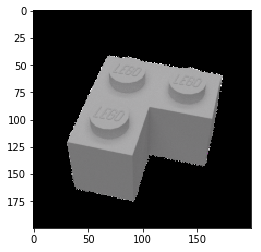

In [0]:
# printing image without 4th channel
img_array_1 = img_array[:,:,:3]
plt.imshow(img_array_1)
plt.show()

The only change is black background instead of transparent. I think CNN can cope with that. Now i need to redefine ImageDataGenerator's flow_from_directory method to account for the change in the number of channels in generated images.

In [0]:
# invoking flow_from_directory method to generate batches of augmented images 

batch_size=16
h, w = 200, 200

train_flow = train_generator.flow_from_directory(
    directory=train_data_dir, 
    target_size=(h,w), color_mode="rgb", class_mode="categorical", shuffle=True, batch_size=batch_size)

# I need two instances of validation flow: for fit_generator yielding images in batches 
# and for evaluation yielding images one by one (treated as test set)

validation_flow_fit = validation_generator.flow_from_directory(
    directory=validation_data_dir, 
    target_size=(h,w), color_mode="rgb", class_mode="categorical", shuffle=True, batch_size=batch_size)

validation_flow_eval = validation_generator.flow_from_directory(
    directory=validation_data_dir, 
    target_size=(h,w), color_mode="rgb", class_mode="categorical", batch_size=1)

test_flow = test_generator.flow_from_directory(
    directory=test_data_dir, 
    target_size=(h,w), color_mode="rgb", class_mode=None, batch_size=1)

Found 4459 images belonging to 16 classes.
Found 1920 images belonging to 16 classes.
Found 1920 images belonging to 16 classes.
Found 16 images belonging to 1 classes.


In [0]:
# defining base model without top fully-connected layer
model = Xception(weights='imagenet',include_top=False,input_shape=(200,200,3))

# adding Dense layers for classification
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(16, activation='softmax'))

# merging base model and new Dense layers
model_transfer = Sequential()
model_transfer.add(model)
model_transfer.add(top_model)

# freezing weights in convolutional part
model_transfer.layers[0].trainable = False

model_transfer.summary()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


83689472/83683744 [==============================] - 4s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
sequential_1 (Sequential)    (None, 16)                25694480  
Total params: 46,555,960
Trainable params: 25,694,480
Non-trainable params: 20,861,480
_________________________________________________________________


In [0]:
# compiling model
model_transfer.compile(loss="categorical_crossentropy",
               optimizer="adam", 
               metrics=["categorical_accuracy"])

In [0]:
# evaluating model on validation set
transfer_accuracy = evaluate_model(model_transfer, model_transfer)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Epoch 1/50
278/278 [==============================] - 2189s 8s/step - loss: 14.5634 - categorical_accuracy: 0.0913 - val_loss: 14.3720 - val_categorical_accuracy: 0.1083
Epoch 2/50
278/278 [==============================] - 93s 333ms/step - loss: 14.0225 - categorical_accuracy: 0.1259 - val_loss: 15.0259 - val_categorical_accuracy: 0.0651
Epoch 3/50
278/278 [==============================] - 91s 328ms/step - loss: 13.2141 - categorical_accuracy: 0.1722 - val_loss: 13.8205 - val_categorical_accuracy: 0.1396
Epoch 4/50
278/278 [==============================] - 90s 325ms/step - loss: 12.0578 - categorical_accuracy: 0.2415 - val_loss: 12.0741 - val_categorical_accuracy: 0.2479
Epoch 5/50
278/278 [==============================] - 90s 325ms/step - loss: 11.4082 - categorical_accuracy: 0.2815 - val_loss: 12.4261 - val_categorical_accuracy: 0.2229
Epoch 6/50
278/278 [==============================] - 89s 322ms/step - loss: 10.8210 - categorical_accuracy: 0.3167 - val_loss: 11.9990 - val_cate

ValueError: ignored

In [0]:
# evaluating model on validation set
transfer_accuracy = evaluate_model(model_transfer, "transfer_model")

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Epoch 1/50
278/278 [==============================] - 94s 339ms/step - loss: 0.4882 - categorical_accuracy: 0.8315 - val_loss: 2.0769 - val_categorical_accuracy: 0.4740
Epoch 2/50
278/278 [==============================] - 92s 329ms/step - loss: 0.4410 - categorical_accuracy: 0.8458 - val_loss: 3.5660 - val_categorical_accuracy: 0.4635
Epoch 3/50
278/278 [==============================] - 92s 331ms/step - loss: 0.4479 - categorical_accuracy: 0.8438 - val_loss: 1.7988 - val_categorical_accuracy: 0.5036
Epoch 4/50
278/278 [==============================] - 92s 330ms/step - loss: 0.4490 - categorical_accuracy: 0.8401 - val_loss: 2.1356 - val_categorical_accuracy: 0.5094
Epoch 5/50
278/278 [==============================] - 91s 327ms/step - loss: 0.4354 - categorical_accuracy: 0.8546 - val_loss: 2.6764 - val_categorical_accuracy: 0.4828
Epoch 6/50
278/278 [==============================] - 91s 329ms/step - loss: 0.4026 - categorical_accuracy: 0.8548 - val_loss: 2.2438 - val_categorical_acc

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Pre-trained network performed rather poorly as it reached almost 50% accuracy on validation set and was heavily overfitted with the difference between accuracy on train and validation sets reaching 35 percentage points. It's due to the fact that my dataset and the dataset the networked was trained on are not very similar. Pre-trained networks implemented in Keras like Xception were trained on ImageNet dataset with 1000 classes of images. There were no classes for different-shaped bricks. Moreover, the classes in ImageNet are more abstract so the network was trained to look for higher-order features than merely shapes. To properly use transfer learning in this case I would have to train some top convolutional layers on my dataset or just use some bottom convolutional layers which recognise more basic features like shapes. 